# Introduction Apple Banana Tomato Classification ResNet50


[Fruits 360](https://www.kaggle.com/moltean/fruits)

- A dataset with 90380 images of 131 fruits and vegetables

- <img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" scale="0">

- This work is licensed under a 
<a rel="license" href="https://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>


# 1. Get images

In [1]:
!git clone https://github.com/lacakp/fruit-ds.git

Cloning into 'fruit-ds'...
remote: Enumerating objects: 17142, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 17142 (delta 0), reused 0 (delta 0), pack-reused 17133
Receiving objects: 100% (17142/17142), 376.47 MiB | 29.28 MiB/s, done.
Resolving deltas: 100% (49/49), done.


## Check images

In [2]:
print("All train image in 3 class apple, banana, tomato")
!ls /content/fruit-ds/train/*/* | wc -l 

print("\n------------------")

print("Apple image count")
!ls /content/fruit-ds/train/apple/* | wc -l 

print("\n------------------")

print("Banana Image Count")
!ls /content/fruit-ds/train/banana/* | wc -l 

print("\n------------------")

print("Tomato Image Count")
!ls /content/fruit-ds/train/tomato/* | wc -l 

All train image in 3 class apple, banana, tomato
8003

------------------
Apple image count
3354

------------------
Banana Image Count
1430

------------------
Tomato Image Count
3219


# 2. Preparing train and validation data

### Import libraly

In [9]:
import tensorflow as tf

TensorFlow เป็นไลบรารีสำหรับใช้พัฒนา machine learning เป็น Open source (เขียนด้วย Python) ที่พัฒนาโดยกูเกิล โดยกูเกิลได้ปล่อย TensorFlow ซึ่งเป็นไลบรารีสำหรับใช้พัฒนา machine learning ที่ใช้งานกันในกูเกิลเอง ให้กลายเป็นโปรแกรม Open source (ใช้ Apache 2.0 สามารถนำไปใช้เพื่อการค้าได้) และมาพร้อมกับ TensorBoard

### Setting path and shape image

In [10]:
train_data_path = '/content/fruit-ds/train'
height = 224
width = 224
batch_size = 32

batch_size ขนาดของ Batch ซึ่งก็คือจำนวนรายการข้อมูลที่จะให้ Optimiser คำนวนในหนึ่งครั้ง เช่น ข้อมูลมี 2,000 รายการ ถ้ากำหนด Batch size เป็น 32 แปลว่า Optimiser จะต้องทำงาน 62.5 ครั้ง จึงจะครบทั้ง 2,000 รายการ และถ้ากำหนด Epoch เป็น 20 ก็หมายถึงการทำงาน 62.5 ครั้ง 20 รอบ

### Training data

split image from path 70% to training data

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_path,
    validation_split = 0.3,
    subset = 'training',
    seed = 123,
    image_size = (height, width),
    batch_size = batch_size
)

Found 8003 files belonging to 3 classes.
Using 5603 files for training.


### Validation data

In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_path,
    validation_split = 0.3,
    subset = 'validation',
    seed = 123,
    image_size = (height, width),
    batch_size = batch_size
)

Found 8003 files belonging to 3 classes.
Using 2400 files for validation.


### Get Class

In [13]:
classes = train_ds.class_names
print(classes)
print(train_ds)

['apple', 'banana', 'tomato']
<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


# 3. Training the model

## Import ResNet50

In [1]:
from tensorflow.keras.applications import ResNet50

In [2]:
model = ResNet50(weights='imagenet')

## Modifying the model

In [3]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Import libraly

In [4]:
from keras import Model
from keras.layers import Dense

### Custom model

In [14]:
abt_output = Dense(3, activation='softmax')
abt_output = abt_output(model.layers[-2].output)

abt_input = model.input
abt_model = Model(inputs=abt_input, outputs=abt_output)

for layer in abt_model.layers[:-1]:
  layer.trainable = False

### Compile model

In [15]:
abt_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

ทำการ รวบรวมโมเดล (Compile model) เพื่อให้พร้อมสำหรับการฝึก ในการคอมไพล์นี้ เราต้องระบุ 3 พารามิเตอร์คือ 

__Loss__

 คือฟังก์ชันชันการสูญเสีย ซึ่งเป็นอัลกอริทึมที่กำหนดว่าการคาดการณ์หรือการทำนายของโมเดลผิดพลาดเพียงใด เป้าหมายของการฝึก (Train) คือการลดความสูญเสีย (loss) เราจะใช้ sparse categorical crossentropy ซึ่งถือว่า ถ้าค่า เลเบลเป็น 0 หมายความว่า เซลล์ประสาทแรกในเลเยอร์เอาต์พุต ทำงานมากที่สุด เช่นกันหากการทำงานที่ค่า เลเบล 1 หมายความว่าเซลล์ประสาทที่สองทำงานมากที่สุด และเลเบลที่ 2 แสดงว่าเซลล์ประสาทที่สามทำงานมากที่สุดนั่นเอง

__Optimizer__

เราจะระบุอัลกอริทึมที่จะใช้ในการปรับน้ำหนักในแบบจำลอง (Model) ซึ่งเราจะใช้ Adam 

__Accuracy__
 คือความแม่นยำของโมเดลว่า ทำนายได้แม่นยำเพียงใด (ในส่วนนี้เป็นการแสดงภาพไม่ได้ส่งผลใดๆในการเทรน)


In [16]:
abt_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

## Training

การเทรนโมเดล เราเพียงแค่เรียกใช้ฟังก์ชัน fit() ระหว่างการฝึก โมเดลจะถูกปรับเพื่อลดค่า loss ให้เหลือน้อยที่สุด epochs คือ การระบุจำนวนครั้งที่ทำการเทรน เราระบุ 10 epoch หมายถึงเราทำการเรียกใช้ ฟังก์ชัน fit() 10 ครั้งติดต่อกันด้วยข้อมูลเดียวกัน

In [17]:
ABTFruit = abt_model.fit(train_ds,
                     validation_data = val_ds, 
                     epochs=4
                     )

Epoch 1/4
176/176 [==============================] - 63s 323ms/step - loss: 0.1485 - accuracy: 0.9523 - val_loss: 0.0180 - val_accuracy: 0.9996
Epoch 2/4
176/176 [==============================] - 55s 314ms/step - loss: 0.0122 - accuracy: 0.9998 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 3/4
176/176 [==============================] - 55s 314ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 4/4
176/176 [==============================] - 56s 315ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000


# 4. Prediction and Evaluation Model




## Graph

In [18]:
import matplotlib.pyplot as plt

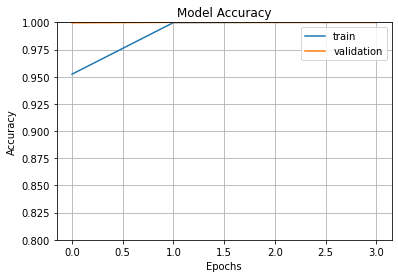

In [19]:
# Model Accuracy
plt.plot(ABTFruit.history['accuracy'])
plt.plot(ABTFruit.history['val_accuracy'])
plt.axis(ymin=0.8, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

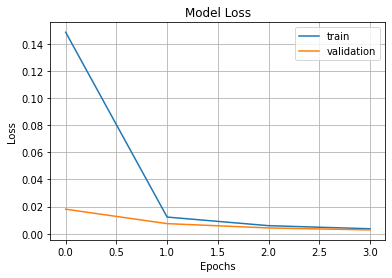

In [20]:
# Model Loss
plt.plot(ABTFruit.history['loss'])
plt.plot(ABTFruit.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## Predictions

### Import library

In [21]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

### Prediction values

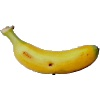

[[2.7071046e-06 9.9999690e-01 4.1696882e-07]]
<class 'numpy.ndarray'>


In [22]:
image = cv2.imread('/content/fruit-ds/test/banana/banana (10).jpg')
cv2_imshow(image)
resized = cv2.resize(image, (224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(resized)
img_array = tf.expand_dims(img_array, 0)
pred = abt_model.predict(img_array)
print(pred)
print(type(pred))

In [23]:
score = pred[0]
print(score)
print("แอปเปิล {:.2f} %".format(score[0]*100))
print("กล้วย {:.2f} %".format(score[1]*100))
print("มะเขือเทศ {:.2f} %".format(score[2]*100))

[2.7071046e-06 9.9999690e-01 4.1696882e-07]
แอปเปิล 0.00 %
กล้วย 100.00 %
มะเขือเทศ 0.00 %


## prediction from test image

### Setting path of test images

In [24]:
test_data_path = '/content/fruit-ds/test'

### Prediction function

In [25]:
def abt_predict(image):
  """
  ฟังก์ชันสำหรับการทำนายภาพผลไม้ แอปเปื้ล กล้วย และมะเขือเทศ
  Prediction Function 
  args: image (<class 'numpy.ndarray'>)
  """
  resized = cv2.resize(image, (224, 224))
  img_array = tf.keras.preprocessing.image.img_to_array(resized)
  img_array = tf.expand_dims(img_array, 0)
  pred = abt_model.predict(img_array)
  score = pred[0]

  result = np.argmax(score)
  if result == 0:
    print('prediction: this is apple')
  if result == 1:
    print('prediction: this is banana')
  if result == 2:
    print("prediction: this is tomato")

  print("prediction score: Apple {:.2f} %".format(score[0]*100))
  print("prediction score: Banana {:.2f} %".format(score[1]*100))
  print("prediction score: Tomato {:.2f} %".format(score[2]*100))
  print("----------")
  return score

### view count of image and import library for random

In [26]:
print("All test image in 3 class apple, banana, tomato")
!ls /content/fruit-ds/test/*/* | wc -l 

print("\n------------------")

print("Apple image count")
!ls /content/fruit-ds/test/apple/* | wc -l 

print("\n------------------")

print("Banana Image Count")
!ls /content/fruit-ds/test/banana/* | wc -l 

print("\n------------------")

print("Tomato Image Count")
!ls /content/fruit-ds/test/tomato/* | wc -l 

All test image in 3 class apple, banana, tomato
2938

------------------
Apple image count
1100

------------------
Banana Image Count
484

------------------
Tomato Image Count
1354


### prediction use predict function by random image from test folder

In [27]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from random import randint

#### Apple

In [82]:
# Apple
apple_pred = []

for i in range(1100):
  try:
    im = cv2.imread(f'{test_data_path}/apple/apple ({randint(1,1099)}).jpg')
    print(f"apple figure({i+1})")
    # cv2_imshow(cv2.resize(im, (30, 30)))
    apple_pred.append(abt_predict(im))
  except:
    pass


Streaming output truncated to the last 5000 lines.
apple figure(261)
prediction: this is apple
prediction score: Apple 99.99 %
prediction score: Banana 0.01 %
prediction score: Tomato 0.00 %
----------
apple figure(262)
prediction: this is apple
prediction score: Apple 99.98 %
prediction score: Banana 0.02 %
prediction score: Tomato 0.00 %
----------
apple figure(263)
prediction: this is apple
prediction score: Apple 99.99 %
prediction score: Banana 0.01 %
prediction score: Tomato 0.00 %
----------
apple figure(264)
prediction: this is apple
prediction score: Apple 100.00 %
prediction score: Banana 0.00 %
prediction score: Tomato 0.00 %
----------
apple figure(265)
prediction: this is apple
prediction score: Apple 100.00 %
prediction score: Banana 0.00 %
prediction score: Tomato 0.00 %
----------
apple figure(266)
prediction: this is apple
prediction score: Apple 99.99 %
prediction score: Banana 0.00 %
prediction score: Tomato 0.01 %
----------
apple figure(267)
prediction: this is app

In [83]:
len(apple_pred)

1090

In [97]:
def acc_average(abt_pred, label):
  all_abt_score = []
  for a in range(len(abt_pred)):
    abt_score = abt_pred[a][label]  # 0.96574855, 0.09570242, 0.9885767 ... 0.9686046
    abt_score = abt_score * 100  # 96.57485485076904, 9.57024171948433 ... 96.86046242713928
    abt_score = float("{:.2f}".format(abt_score)) # 96.57, 9.836 ... 96.86
    all_abt_score.append(abt_score) # append to list

  pred_average = sum(all_abt_score) / len(all_abt_score)

  return pred_average

In [98]:
acc_average_apple = acc_average(apple_pred, 0)
print("Apple average accuracy {:.2f} %".format(acc_average_apple))

Apple average accuracy 99.97 %


#### Banana

In [99]:
# Banana
banana_pred = []
for i in range(484):
  try:
    im = cv2.imread(f'{test_data_path}/banana/banana ({randint(1,480)}).jpg')
    print(f"banana figure({i+1})")
    # cv2_imshow(cv2.resize(im, (30, 30)))
    banana_pred.append(abt_predict(im))
  except:
    pass

banana figure(1)
prediction: this is banana
prediction score: Apple 0.01 %
prediction score: Banana 99.99 %
prediction score: Tomato 0.00 %
----------
banana figure(2)
prediction: this is banana
prediction score: Apple 0.00 %
prediction score: Banana 100.00 %
prediction score: Tomato 0.00 %
----------
banana figure(3)
prediction: this is banana
prediction score: Apple 0.02 %
prediction score: Banana 99.98 %
prediction score: Tomato 0.00 %
----------
banana figure(4)
prediction: this is banana
prediction score: Apple 0.00 %
prediction score: Banana 100.00 %
prediction score: Tomato 0.00 %
----------
banana figure(5)
prediction: this is banana
prediction score: Apple 0.00 %
prediction score: Banana 100.00 %
prediction score: Tomato 0.00 %
----------
banana figure(6)
prediction: this is banana
prediction score: Apple 0.01 %
prediction score: Banana 99.99 %
prediction score: Tomato 0.00 %
----------
banana figure(7)
prediction: this is banana
prediction score: Apple 0.04 %
prediction score

In [88]:
len(banana_pred)

484

In [89]:
def acc_average(abt_pred, label):
  all_abt_score = []
  for a in range(len(abt_pred)):
    abt_score = abt_pred[a][label]  # 0.96574855, 0.09570242, 0.9885767 ... 0.9686046
    abt_score = abt_score * 100  # 96.57485485076904, 9.57024171948433 ... 96.86046242713928
    abt_score = float("{:.2f}".format(abt_score)) # 96.57, 9.836 ... 96.86
    all_abt_score.append(abt_score) # append to list

  pred_average = sum(all_abt_score) / len(all_abt_score)

  return pred_average

In [90]:
acc_average_banana = acc_average(banana_pred, 1)
print("Banana average accuracy {:.2f} %".format(acc_average_banana))

Banana average accuracy 99.97 %


#### Tomato

In [91]:
# Tomato

tomato_pred = []
for i in range(1354):
  try:
    im = cv2.imread(f'{test_data_path}/tomato/tomato ({randint(1,1000)}).jpg')
    print(f"tomato figure({i+1})")
    # cv2_imshow(cv2.resize(im, (30, 30)))
    tomato_pred.append(abt_predict(im))
  except:
    pass

Streaming output truncated to the last 5000 lines.
prediction score: Tomato 89.23 %
----------
tomato figure(522)
prediction: this is tomato
prediction score: Apple 3.10 %
prediction score: Banana 0.72 %
prediction score: Tomato 96.18 %
----------
tomato figure(523)
prediction: this is tomato
prediction score: Apple 0.26 %
prediction score: Banana 0.05 %
prediction score: Tomato 99.69 %
----------
tomato figure(524)
prediction: this is tomato
prediction score: Apple 0.01 %
prediction score: Banana 0.00 %
prediction score: Tomato 99.99 %
----------
tomato figure(525)
prediction: this is tomato
prediction score: Apple 0.04 %
prediction score: Banana 0.02 %
prediction score: Tomato 99.94 %
----------
tomato figure(526)
prediction: this is tomato
prediction score: Apple 20.89 %
prediction score: Banana 0.12 %
prediction score: Tomato 78.99 %
----------
tomato figure(527)
prediction: this is tomato
prediction score: Apple 42.00 %
prediction score: Banana 0.07 %
prediction score: Tomato 57.9

In [92]:
len(tomato_pred)

1354

In [93]:
def acc_average(abt_pred, label):
  all_abt_score = []
  for a in range(len(abt_pred)):
    abt_score = abt_pred[a][label]  # 0.96574855, 0.09570242, 0.9885767 ... 0.9686046
    abt_score = abt_score * 100  # 96.57485485076904, 9.57024171948433 ... 96.86046242713928
    abt_score = float("{:.2f}".format(abt_score)) # 96.57, 9.836 ... 96.86
    all_abt_score.append(abt_score) # append to list

  pred_average = sum(all_abt_score) / len(all_abt_score)

  return pred_average

In [94]:
acc_average_tomato = acc_average(tomato_pred, 2)
print("Tomato average accuracy {:.2f} %".format(acc_average_tomato))

Tomato average accuracy 96.60 %


# 5. Deploy Model

## Save Model

In [96]:
abt_model.save('abt_resnetmodel_09_11_2021', save_format='h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
